# OpenVINO Training Extension - Object Detection
In this tutorial, we will go through 
  * Train a ATSS-MobileNetV2 detection model with a demo dataset
  * Perform inference on the trained model
  * Export PyTorch model to OpenVINO IR and perform benchmark with [OpenVINO Benchmark App](https://docs.openvino.ai/latest/openvino_inference_engine_tools_benchmark_tool_README.html#benchmark-python-tool)
  * Quantize OpenVINO IR with [Post-Training Optimization Toolkit](https://docs.openvino.ai/latest/pot_introduction.html)
  * Compress PyTorch model with [NNCF](https://github.com/openvinotoolkit/nncf)

## Import everything

In [1]:
import os
import sys

import cv2
import numpy as np

from ote_sdk.configuration.helper import create as create_parameters_from_parameters_schema
from ote_sdk.entities.inference_parameters import InferenceParameters
from ote_sdk.entities.label_schema import LabelSchemaEntity
from ote_sdk.entities.model import ModelEntity, ModelOptimizationType
from ote_sdk.entities.resultset import ResultSetEntity
from ote_sdk.entities.subset import Subset
from ote_sdk.entities.task_environment import TaskEnvironment
from ote_sdk.entities.optimization_parameters import OptimizationParameters
from ote_sdk.usecases.adapters.model_adapter import ModelAdapter
from ote_sdk.usecases.tasks.interfaces.export_interface import ExportType
from ote_sdk.usecases.tasks.interfaces.optimization_interface import OptimizationType

from ote_cli.datasets import get_dataset_class
from ote_cli.registry import Registry
from ote_cli.utils.importing import get_impl_class
from ote_cli.utils.io import read_binary, save_model_data

/home/yuchunli/git/training_extensions/external/model-preparation-algorithm/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## List templates
Currently, we provided 3 model templates for object detections: ATSS-MobileNetV2, SSD-MobileNetV2, and YOLOX-CSPDarkNet.  
We picked these templates as they deliver the best performance-accuracy trade-off.

In [2]:
templates_dir = '../external'
registry = Registry(templates_dir)
print(registry)

- id: Custom_Rotated_Detection_via_Instance_Segmentation_MaskRCNN_ResNet50
  name: MaskRCNN-ResNet50
  path: /home/yuchunli/git/training_extensions/external/model-preparation-algorithm/configs/rotated-detection/resnet50_maskrcnn/template.yaml
  task_type: ROTATED_DETECTION
- id: Custom_Rotated_Detection_via_Instance_Segmentation_MaskRCNN_EfficientNetB2B
  name: MaskRCNN-EfficientNetB2B
  path: /home/yuchunli/git/training_extensions/external/model-preparation-algorithm/configs/rotated-detection/efficientnetb2b_maskrcnn/template.yaml
  task_type: ROTATED_DETECTION
- id: Custom_Counting_Instance_Segmentation_MaskRCNN_ResNet50
  name: MaskRCNN-ResNet50
  path: /home/yuchunli/git/training_extensions/external/model-preparation-algorithm/configs/instance-segmentation/resnet50_maskrcnn/template.yaml
  task_type: INSTANCE_SEGMENTATION
- id: Custom_Counting_Instance_Segmentation_MaskRCNN_EfficientNetB2B
  name: MaskRCNN-EfficientNetB2B
  path: /home/yuchunli/git/training_extensions/external/mode

## Load ATSS-MobileNetV2 template and its hyper parameters

In [3]:
model_template = registry.get('Custom_Object_Detection_Gen3_ATSS')
hyper_parameters = model_template.hyper_parameters.data

## Load the Demo dataset

In [4]:
Dataset = get_dataset_class(model_template.task_type)

dataset = Dataset(
    train_subset={'ann_file': '../data/airport/annotation_faces_train.json',
                  'data_root': '../data/airport/'},
    val_subset={'ann_file': '../data/airport/annotation_faces_train.json',
                'data_root': '../data/airport'}
)
labels_schema = LabelSchemaEntity.from_labels(dataset.get_labels())

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


## Tune the Configurable Parameters
A set of configurable parameters is available for tuning

In [5]:
hyper_parameters = create_parameters_from_parameters_schema(hyper_parameters)

for p in hyper_parameters.learning_parameters.parameters:
    print(f'{p}: {getattr(hyper_parameters.learning_parameters, p)}')

batch_size: 8
early_stop_iteration_patience: 0
early_stop_patience: 10
early_stop_start: 3
enable_early_stopping: True
learning_rate: 0.004
learning_rate_warmup_iters: 3
num_checkpoints: 5
num_iters: 200
num_workers: 2
use_adaptive_interval: True


### Tweak parameters
In order to get a working model swiftly, change the number of iterations (epochs) to 15

In [6]:
hyper_parameters.learning_parameters.batch_size = 8
hyper_parameters.learning_parameters.num_iters = 15

for p in hyper_parameters.learning_parameters.parameters:
    print(f'{p}: {getattr(hyper_parameters.learning_parameters, p)}')

batch_size: 8
early_stop_iteration_patience: 0
early_stop_patience: 10
early_stop_start: 3
enable_early_stopping: True
learning_rate: 0.004
learning_rate_warmup_iters: 3
num_checkpoints: 5
num_iters: 15
num_workers: 2
use_adaptive_interval: True


## Create Detection Task 
Create `DetectionTrainTask` interface for training/inference/exportation

In [7]:
Task = get_impl_class(model_template.entrypoints.base)

environment = TaskEnvironment(
    model=None,
    hyper_parameters=hyper_parameters,
    label_schema=labels_schema,
    model_template=model_template)
        
task = Task(task_environment=environment)

2022-11-02 14:58:36,105 | INFO : created output path at /tmp/MPA-task-6zoh2i81


### Train

In [8]:
torch_model = ModelEntity(
    dataset,
    environment.get_model_configuration(),
)

task.train(dataset, torch_model)
save_model_data(torch_model, "./torch_model")

2022-11-02 14:58:36,171 | INFO : train()
2022-11-02 14:58:36,173 | INFO : init data cfg.
2022-11-02 14:58:36,175 | INFO : initializing....
2022-11-02 14:58:36,176 | INFO : called _init_recipe()
2022-11-02 14:58:36,177 | INFO : train type = Incremental
2022-11-02 14:58:36,208 | WARNING : Duplicate key is detected among bases [{'data', 'data_root_path'}]
2022-11-02 14:58:36,211 | INFO : initialized recipe = /home/yuchunli/git/training_extensions/external/model-preparation-algorithm/submodule/recipes/stages/detection/imbalance.py
2022-11-02 14:58:36,218 | WARNING : Duplicate key is detected among bases [{'model'}]
2022-11-02 14:58:36,219 | INFO : initialized.
2022-11-02 14:58:36,220 | INFO : running task... kwargs = {}
2022-11-02 14:58:36,221 | INFO : called build_recipe()
2022-11-02 14:58:36,222 | INFO : seems to be passed stage yaml...
2022-11-02 14:58:36,223 | INFO : build_stage()
2022-11-02 14:58:36,227 | INFO : Training seed was set to 5 w/ deterministic=False.
2022-11-02 14:58:36,22

2022-11-02 14:58:37,082 - mmdet - WARNING - Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


[ WARNING ] Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


[ WARNING ]  Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


Use load_from_http loader
2022-11-02 14:58:39,713 | INFO : ----------------- CustomATSS.load_state_dict_pre_hook() called w/ prefix: 
2022-11-02 14:58:39,714 | INFO : [] -> ['face'] ([-1])
2022-11-02 14:58:39,745 | INFO : Task Adaptation: [] => ['face']
2022-11-02 14:58:39,745 | INFO : - Efficient Mode: False
2022-11-02 14:58:39,746 | INFO : - Sampler type: cls_incr
2022-11-02 14:58:39,747 | INFO : - Sampler flag: False


2022-11-02 14:58:39,748 - mmdet - INFO - Start running, host: yuchunli@yuchunli-desk, work_dir: /tmp/MPA-task-6zoh2i81/stage00_DetectionTrainer-train


[ INFO ] Start running, host: yuchunli@yuchunli-desk, work_dir: /tmp/MPA-task-6zoh2i81/stage00_DetectionTrainer-train


[ INFO ]  Start running, host: %s, work_dir: %s
2022-11-02 14:58:39,750 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) ReduceLROnPlateauLrUpdaterHook     
(ABOVE_NORMAL) Fp16OptimizerHook                  
(ABOVE_NORMAL) EMAHook                            
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(NORMAL      ) CancelInterfaceHook                
(NORMAL      ) LoggerReplaceHook                  
(71          ) OTEProgressHook                    
(75          ) LazyEarlyStoppingHook              
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) TensorboardLoggerHook              
(VERY_LOW    ) OTELoggerHook                      
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) ReduceLROnPlateauLrUpdaterHook     
(ABOVE_NORMAL) EMAHook                            
(NORMAL      ) EvalHook                           
(NORMAL      ) TaskAdaptHook                

[ INFO ] Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) ReduceLROnPlateauLrUpdaterHook     
(ABOVE_NORMAL) Fp16OptimizerHook                  
(ABOVE_NORMAL) EMAHook                            
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(NORMAL      ) CancelInterfaceHook                
(NORMAL      ) LoggerReplaceHook                  
(71          ) OTEProgressHook                    
(75          ) LazyEarlyStoppingHook              
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) TensorboardLoggerHook              
(VERY_LOW    ) OTELoggerHook                      
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) ReduceLROnPlateauLrUpdaterHook     
(ABOVE_NORMAL) EMAHook                            
(NORMAL      ) EvalHook                           
(NORMAL      ) TaskAdaptHook                      
(LOW         ) IterTimerHook                      
(71          ) OTEProg

[ INFO ]  Hooks will be executed in the following order:
%s
2022-11-02 14:58:39,752 - mmdet - INFO - workflow: [('train', 1)], max: 15 epochs


[ INFO ] workflow: [('train', 1)], max: 15 epochs


[ INFO ]  workflow: %s, max: %d epochs


2022-11-02 14:58:39,770 | INFO : cancel hook is initialized
2022-11-02 14:58:39,771 | INFO : logger in the runner is replaced to the MPA logger


2022-11-02 14:58:43,736 - mmcls - WARNING - training progress 3%


[ WARNING ] training progress 3%


[ WARNING ]  training progress 3%


2022-11-02 14:58:43,741 | INFO : Epoch [1][1/2]	lr: 1.333e-03, eta: 3:07:44, time: 3.884, data_time: 0.528, memory: 4665, current_iters: 0, loss_cls: 1.1677, loss_bbox: 1.4771, loss_centerness: 0.7214, loss: 3.3661, grad_norm: 10.9902
2022-11-02 14:58:44,288 | INFO : Exp name: /tmp/MPA-task-6zoh2i81/stage00_DetectionTrainer-train
2022-11-02 14:58:44,289 | INFO : Epoch [1][2/2]	lr: 2.222e-03, eta: 2:22:23, time: 2.218, data_time: 0.271, memory: 4685, current_iters: 1, loss_cls: 1.1619, loss_bbox: 1.4615, loss_centerness: 0.7152, loss: 3.3386, grad_norm: 12.0243
2022-11-02 14:58:44,393 | INFO : Saving checkpoint at 1 epochs
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 18.5 task/s, elapsed: 1s, ETA:     0s
---------------iou_thr: 0.5---------------
2022-11-02 14:58:45,325 | INFO : 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| face  | 41  | 0    | 0.000  | 0.000 |
+-------+-----+------+--------+-------+
| mAP   |    

2022-11-02 14:58:46,426 - mmcls - WARNING - training progress 10%


[ WARNING ] training progress 10%


[ WARNING ]  training progress 10%


2022-11-02 14:58:46,431 | INFO : Epoch [2][1/2]	lr: 3.111e-03, eta: 1:45:50, time: 0.954, data_time: 0.501, memory: 4685, current_iters: 2, loss_cls: 1.1205, loss_bbox: 1.0048, loss_centerness: 0.7017, loss: 2.8269, grad_norm: 12.2649
2022-11-02 14:58:47,000 | INFO : Exp name: /tmp/MPA-task-6zoh2i81/stage00_DetectionTrainer-train
2022-11-02 14:58:47,001 | INFO : Epoch [2][2/2]	lr: 4.000e-03, eta: 1:24:43, time: 0.764, data_time: 0.265, memory: 4685, current_iters: 3, loss_cls: 1.0836, loss_bbox: 1.0101, loss_centerness: 0.6798, loss: 2.7734, grad_norm: 9.8943
2022-11-02 14:58:47,115 | INFO : Saving checkpoint at 2 epochs
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 17.3 task/s, elapsed: 1s, ETA:     0s
---------------iou_thr: 0.5---------------
2022-11-02 14:58:48,096 | INFO : 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| face  | 41  | 0    | 0.000  | 0.000 |
+-------+-----+------+--------+-------+
| mAP   |     

2022-11-02 14:58:49,838 - mmcls - WARNING - training progress 20%


[ WARNING ] training progress 20%


[ WARNING ]  training progress 20%


2022-11-02 14:58:49,840 | INFO : Exp name: /tmp/MPA-task-6zoh2i81/stage00_DetectionTrainer-train
2022-11-02 14:58:49,840 | INFO : Epoch [3][2/2]	lr: 4.000e-03, eta: 1:04:42, time: 0.815, data_time: 0.279, memory: 4685, current_iters: 5, loss_cls: 0.8817, loss_bbox: 0.8569, loss_centerness: 0.6556, loss: 2.3942, grad_norm: 7.3157
2022-11-02 14:58:49,947 | INFO : Saving checkpoint at 3 epochs
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 17.8 task/s, elapsed: 1s, ETA:     0s
---------------iou_thr: 0.5---------------
2022-11-02 14:58:50,919 | INFO : 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| face  | 41  | 0    | 0.000  | 0.000 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.000 |
+-------+-----+------+--------+-------+
2022-11-02 14:58:51,000 | INFO : Exp name: /tmp/MPA-task-6zoh2i81/stage00_DetectionTrainer-train
2022-11-02 14:58:51,001 | INFO : Epoch(val) [3][2]	AP50: 0.0000, mAP: 0.

2022-11-02 14:58:54,860 - mmcls - WARNING - training progress 30%


[ WARNING ] training progress 30%


[ WARNING ]  training progress 30%


2022-11-02 14:58:54,865 | INFO : Epoch [5][1/2]	lr: 4.000e-03, eta: 0:49:18, time: 1.023, data_time: 0.481, memory: 4685, current_iters: 8, loss_cls: 0.6108, loss_bbox: 0.6345, loss_centerness: 0.6205, loss: 1.8659, grad_norm: 16.5524
2022-11-02 14:58:55,433 | INFO : Exp name: /tmp/MPA-task-6zoh2i81/stage00_DetectionTrainer-train
2022-11-02 14:58:55,434 | INFO : Epoch [5][2/2]	lr: 4.000e-03, eta: 0:44:55, time: 0.798, data_time: 0.257, memory: 4685, current_iters: 9, loss_cls: 0.4461, loss_bbox: 0.7017, loss_centerness: 0.6307, loss: 1.7786, grad_norm: 12.1637
2022-11-02 14:58:55,545 | INFO : Saving checkpoint at 5 epochs
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 17.2 task/s, elapsed: 1s, ETA:     0s
---------------iou_thr: 0.5---------------
2022-11-02 14:58:56,508 | INFO : 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| face  | 41  | 0    | 0.000  | 0.000 |
+-------+-----+------+--------+-------+
| mAP   |    

2022-11-02 14:58:58,267 - mmcls - WARNING - training progress 40%


[ WARNING ] training progress 40%


[ WARNING ]  training progress 40%


2022-11-02 14:58:58,272 | INFO : Exp name: /tmp/MPA-task-6zoh2i81/stage00_DetectionTrainer-train
2022-11-02 14:58:58,274 | INFO : Epoch [6][2/2]	lr: 4.000e-03, eta: 0:38:23, time: 0.821, data_time: 0.267, memory: 4685, current_iters: 11, loss_cls: 0.2022, loss_bbox: 0.6012, loss_centerness: 0.6199, loss: 1.4233, grad_norm: 6.7240
2022-11-02 14:58:58,363 | INFO : Saving checkpoint at 6 epochs
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 17.7 task/s, elapsed: 1s, ETA:     0s
---------------iou_thr: 0.5---------------
2022-11-02 14:58:59,354 | INFO : 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| face  | 41  | 0    | 0.000  | 0.000 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.000 |
+-------+-----+------+--------+-------+
2022-11-02 14:58:59,431 | INFO : Exp name: /tmp/MPA-task-6zoh2i81/stage00_DetectionTrainer-train
2022-11-02 14:58:59,432 | INFO : Epoch(val) [6][2]	AP50: 0.0000, mAP: 0

2022-11-02 14:59:03,408 - mmcls - WARNING - training progress 50%


[ WARNING ] training progress 50%


[ WARNING ]  training progress 50%


2022-11-02 14:59:03,413 | INFO : Epoch [8][1/2]	lr: 4.000e-03, eta: 0:30:33, time: 1.096, data_time: 0.498, memory: 4685, current_iters: 14, loss_cls: 0.1467, loss_bbox: 0.5000, loss_centerness: 0.6322, loss: 1.2790, grad_norm: 7.1519
2022-11-02 14:59:03,980 | INFO : Exp name: /tmp/MPA-task-6zoh2i81/stage00_DetectionTrainer-train
2022-11-02 14:59:03,981 | INFO : Epoch [8][2/2]	lr: 4.000e-03, eta: 0:27:56, time: 0.834, data_time: 0.268, memory: 4685, current_iters: 15, loss_cls: 0.1438, loss_bbox: 0.5655, loss_centerness: 0.6256, loss: 1.3349, grad_norm: 8.0379
2022-11-02 14:59:04,081 | INFO : Saving checkpoint at 8 epochs
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 17.5 task/s, elapsed: 1s, ETA:     0s
---------------iou_thr: 0.5---------------
2022-11-02 14:59:05,023 | INFO : 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| face  | 41  | 30   | 0.585  | 0.516 |
+-------+-----+------+--------+-------+
| mAP   |    

2022-11-02 14:59:06,865 - mmcls - WARNING - training progress 60%


[ WARNING ] training progress 60%


[ WARNING ]  training progress 60%


2022-11-02 14:59:06,869 | INFO : Exp name: /tmp/MPA-task-6zoh2i81/stage00_DetectionTrainer-train
2022-11-02 14:59:06,869 | INFO : Epoch [9][2/2]	lr: 4.000e-03, eta: 0:23:25, time: 0.825, data_time: 0.277, memory: 4685, current_iters: 17, loss_cls: 0.1474, loss_bbox: 0.5234, loss_centerness: 0.6115, loss: 1.2823, grad_norm: 8.5413
2022-11-02 14:59:06,979 | INFO : Saving checkpoint at 9 epochs
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 17.4 task/s, elapsed: 1s, ETA:     0s
---------------iou_thr: 0.5---------------
2022-11-02 14:59:07,944 | INFO : 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| face  | 41  | 37   | 0.732  | 0.677 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.677 |
+-------+-----+------+--------+-------+
2022-11-02 14:59:08,093 | INFO : Now best checkpoint is saved as best_mAP_epoch_9.pth.
2022-11-02 14:59:08,094 | INFO : Best mAP is 0.6775 at 9 epoch.
2022-11-02 14:59:

2022-11-02 14:59:11,867 - mmcls - WARNING - training progress 70%


[ WARNING ] training progress 70%


[ WARNING ]  training progress 70%


2022-11-02 14:59:11,873 | INFO : Epoch [11][1/2]	lr: 4.000e-03, eta: 0:17:00, time: 0.961, data_time: 0.508, memory: 4685, current_iters: 20, loss_cls: 0.1839, loss_bbox: 0.5387, loss_centerness: 0.6435, loss: 1.3661, grad_norm: 8.0949
2022-11-02 14:59:12,460 | INFO : Exp name: /tmp/MPA-task-6zoh2i81/stage00_DetectionTrainer-train
2022-11-02 14:59:12,461 | INFO : Epoch [11][2/2]	lr: 4.000e-03, eta: 0:14:54, time: 0.777, data_time: 0.269, memory: 4685, current_iters: 21, loss_cls: 0.1378, loss_bbox: 0.5426, loss_centerness: 0.6237, loss: 1.3041, grad_norm: 7.9825
2022-11-02 14:59:12,556 | INFO : Saving checkpoint at 11 epochs
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 16.8 task/s, elapsed: 1s, ETA:     0s
---------------iou_thr: 0.5---------------
2022-11-02 14:59:13,561 | INFO : 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| face  | 41  | 54   | 0.927  | 0.885 |
+-------+-----+------+--------+-------+
| mAP   | 

2022-11-02 14:59:15,286 - mmcls - WARNING - training progress 80%


[ WARNING ] training progress 80%


[ WARNING ]  training progress 80%


2022-11-02 14:59:15,289 | INFO : Exp name: /tmp/MPA-task-6zoh2i81/stage00_DetectionTrainer-train
2022-11-02 14:59:15,290 | INFO : Epoch [12][2/2]	lr: 4.000e-03, eta: 0:10:58, time: 0.768, data_time: 0.261, memory: 4685, current_iters: 23, loss_cls: 0.1225, loss_bbox: 0.5476, loss_centerness: 0.6255, loss: 1.2955, grad_norm: 9.3971
2022-11-02 14:59:15,384 | INFO : Saving checkpoint at 12 epochs
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 16.5 task/s, elapsed: 1s, ETA:     0s
---------------iou_thr: 0.5---------------
2022-11-02 14:59:16,355 | INFO : 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| face  | 41  | 59   | 0.927  | 0.900 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.900 |
+-------+-----+------+--------+-------+
2022-11-02 14:59:16,511 | INFO : Now best checkpoint is saved as best_mAP_epoch_12.pth.
2022-11-02 14:59:16,512 | INFO : Best mAP is 0.8997 at 12 epoch.
2022-11-02 14

2022-11-02 14:59:20,477 - mmcls - WARNING - training progress 90%


[ WARNING ] training progress 90%


[ WARNING ]  training progress 90%


2022-11-02 14:59:20,481 | INFO : Epoch [14][1/2]	lr: 4.000e-03, eta: 0:05:25, time: 1.071, data_time: 0.521, memory: 4685, current_iters: 26, loss_cls: 0.1264, loss_bbox: 0.4487, loss_centerness: 0.6018, loss: 1.1770, grad_norm: 7.8831
2022-11-02 14:59:21,018 | INFO : Exp name: /tmp/MPA-task-6zoh2i81/stage00_DetectionTrainer-train
2022-11-02 14:59:21,019 | INFO : Epoch [14][2/2]	lr: 4.000e-03, eta: 0:03:34, time: 0.805, data_time: 0.269, memory: 4685, current_iters: 27, loss_cls: 0.1031, loss_bbox: 0.4528, loss_centerness: 0.5978, loss: 1.1537, grad_norm: 7.9251
2022-11-02 14:59:21,123 | INFO : Saving checkpoint at 14 epochs
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 16.2 task/s, elapsed: 1s, ETA:     0s
---------------iou_thr: 0.5---------------
2022-11-02 14:59:22,128 | INFO : 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| face  | 41  | 66   | 0.976  | 0.957 |
+-------+-----+------+--------+-------+
| mAP   | 

2022-11-02 14:59:23,821 - mmcls - WARNING - training progress 100%


[ WARNING ] training progress 100%


[ WARNING ]  training progress 100%


2022-11-02 14:59:23,824 | INFO : Exp name: /tmp/MPA-task-6zoh2i81/stage00_DetectionTrainer-train
2022-11-02 14:59:23,825 | INFO : Epoch [15][2/2]	lr: 4.000e-03, eta: 0:00:00, time: 0.770, data_time: 0.265, memory: 4685, current_iters: 29, loss_cls: 0.0903, loss_bbox: 0.5056, loss_centerness: 0.6153, loss: 1.2112, grad_norm: 8.2784
2022-11-02 14:59:23,920 | INFO : Saving checkpoint at 15 epochs
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 18.1 task/s, elapsed: 1s, ETA:     0s
---------------iou_thr: 0.5---------------
2022-11-02 14:59:24,827 | INFO : 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| face  | 41  | 67   | 0.976  | 0.965 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.965 |
+-------+-----+------+--------+-------+
2022-11-02 14:59:24,980 | INFO : Now best checkpoint is saved as best_mAP_epoch_15.pth.
2022-11-02 14:59:24,981 | INFO : Best mAP is 0.9651 at 15 epoch.
2022-11-02 14

2022-11-02 14:59:26,187 - mmdet - WARNING - Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


[ WARNING ] Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


[ WARNING ]  Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


Use load_from_local loader
2022-11-02 14:59:26,299 | INFO : ----------------- CustomATSS.load_state_dict_pre_hook() called w/ prefix: 
2022-11-02 14:59:26,300 | INFO : ['face'] -> ['face'] ([0])
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_backbone_features_init_block_conv_weight, ema_backbone_features_init_block_bn_weight, ema_backbone_features_init_block_bn_bias, ema_backbone_features_stage1_unit1_conv1_conv_weight, ema_backbone_features_stage1_unit1_conv1_bn_weight, ema_backbone_features_stage1_unit1_conv1_bn_bias, ema_backbone_features_stage1_unit1_conv2_conv_weight, ema_backbone_features_stage1_unit1_conv2_bn_weight, ema_backbone_features_stage1_unit1_conv2_bn_bias, ema_backbone_features_stage1_unit1_conv3_conv_weight, ema_backbone_features_stage1_unit1_conv3_bn_weight, ema_backbone_features_stage1_unit1_conv3_bn_bias, ema_backbone_features_stage2_unit1_conv1_conv_weight, ema_backbone_features_stage2_unit1_conv1_bn_weight, ema_back

### Run Inference and Evaluate Result

In [9]:
validation_dataset = dataset.get_subset(Subset.VALIDATION)
predicted_validation_dataset = task.infer(
    validation_dataset.with_empty_annotations(),
    InferenceParameters(is_evaluation=True))

torch_resultset = ResultSetEntity(
    model=torch_model,
    ground_truth_dataset=validation_dataset,
    prediction_dataset=predicted_validation_dataset,
)
task.evaluate(torch_resultset)
print(torch_resultset.performance)

2022-11-02 14:59:27,449 | INFO : infer()
2022-11-02 14:59:27,450 | INFO : Confidence threshold 0.125
2022-11-02 14:59:27,452 | INFO : initializing....
2022-11-02 14:59:27,453 | INFO : called _init_recipe()
2022-11-02 14:59:27,456 | INFO : train type = Incremental
2022-11-02 14:59:27,480 | WARNING : Duplicate key is detected among bases [{'data', 'data_root_path'}]
2022-11-02 14:59:27,483 | INFO : initialized recipe = /home/yuchunli/git/training_extensions/external/model-preparation-algorithm/submodule/recipes/stages/detection/imbalance.py
2022-11-02 14:59:27,489 | WARNING : Duplicate key is detected among bases [{'model'}]
2022-11-02 14:59:27,490 | INFO : initialized.
2022-11-02 14:59:27,490 | INFO : running task... kwargs = {'eval': True, 'dump_features': True, 'dump_saliency_map': False}
2022-11-02 14:59:27,491 | INFO : called build_recipe()
2022-11-02 14:59:27,492 | INFO : seems to be passed stage yaml...
2022-11-02 14:59:27,493 | INFO : build_stage()
2022-11-02 14:59:27,495 | INFO 

2022-11-02 14:59:27,551 - mmdet - WARNING - Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


[ WARNING ] Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


[ WARNING ]  Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


Use load_from_local loader
2022-11-02 14:59:27,659 | INFO : ----------------- CustomATSS.load_state_dict_pre_hook() called w/ prefix: 
2022-11-02 14:59:27,660 | INFO : ['face'] -> ['face'] ([0])
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_backbone_features_init_block_conv_weight, ema_backbone_features_init_block_bn_weight, ema_backbone_features_init_block_bn_bias, ema_backbone_features_stage1_unit1_conv1_conv_weight, ema_backbone_features_stage1_unit1_conv1_bn_weight, ema_backbone_features_stage1_unit1_conv1_bn_bias, ema_backbone_features_stage1_unit1_conv2_conv_weight, ema_backbone_features_stage1_unit1_conv2_bn_weight, ema_backbone_features_stage1_unit1_conv2_bn_bias, ema_backbone_features_stage1_unit1_conv3_conv_weight, ema_backbone_features_stage1_unit1_conv3_bn_weight, ema_backbone_features_stage1_unit1_conv3_bn_bias, ema_backbone_features_stage2_unit1_conv1_conv_weight, ema_backbone_features_stage2_unit1_conv1_bn_weight, ema_back

## OpenVINO

### Export PyTorch model to OpenVINO IR

In [10]:
exported_model = ModelEntity(
    dataset,
    environment.get_model_configuration(),
)
task.export(ExportType.OPENVINO, exported_model)
save_model_data(exported_model, "./exported_model")

2022-11-02 14:59:28,658 | INFO : Exporting the model
2022-11-02 14:59:28,661 | INFO : initializing....
2022-11-02 14:59:28,662 | INFO : called _init_recipe()
2022-11-02 14:59:28,663 | INFO : train type = Incremental
2022-11-02 14:59:28,693 | WARNING : Duplicate key is detected among bases [{'data', 'data_root_path'}]
2022-11-02 14:59:28,696 | INFO : initialized recipe = /home/yuchunli/git/training_extensions/external/model-preparation-algorithm/submodule/recipes/stages/detection/imbalance.py
2022-11-02 14:59:28,706 | WARNING : Duplicate key is detected among bases [{'model'}]
2022-11-02 14:59:28,708 | INFO : initialized.
2022-11-02 14:59:28,710 | INFO : running task... kwargs = {'precision': 'FP32', 'export': True}
2022-11-02 14:59:28,711 | INFO : called build_recipe()
2022-11-02 14:59:28,713 | INFO : seems to be passed stage yaml...
2022-11-02 14:59:28,714 | INFO : build_stage()
2022-11-02 14:59:28,718 | INFO : Training seed was set to 5 w/ deterministic=False.
2022-11-02 14:59:28,720

2022-11-02 14:59:28,789 - mmdet - WARNING - Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


[ WARNING ] Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


[ WARNING ]  Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


Use load_from_local loader
2022-11-02 14:59:28,915 | INFO : ----------------- CustomATSS.load_state_dict_pre_hook() called w/ prefix: 
2022-11-02 14:59:28,917 | INFO : ['face'] -> ['face'] ([0])
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_backbone_features_init_block_conv_weight, ema_backbone_features_init_block_bn_weight, ema_backbone_features_init_block_bn_bias, ema_backbone_features_stage1_unit1_conv1_conv_weight, ema_backbone_features_stage1_unit1_conv1_bn_weight, ema_backbone_features_stage1_unit1_conv1_bn_bias, ema_backbone_features_stage1_unit1_conv2_conv_weight, ema_backbone_features_stage1_unit1_conv2_bn_weight, ema_backbone_features_stage1_unit1_conv2_bn_bias, ema_backbone_features_stage1_unit1_conv3_conv_weight, ema_backbone_features_stage1_unit1_conv3_bn_weight, ema_backbone_features_stage1_unit1_conv3_bn_bias, ema_backbone_features_stage2_unit1_conv1_conv_weight, ema_backbone_features_stage2_unit1_conv1_bn_weight, ema_back

[ WARNING ]  
Detected not satisfied dependencies:
	numpy: installed: 1.21.4, required: < 1.20

Please install required versions of components or run pip installation
pip install openvino-dev


[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /tmp/MPA-task-6zoh2i81/stage00_DetectionExporter-train/export/model.xml
[ SUCCESS ] BIN file: /tmp/MPA-task-6zoh2i81/stage00_DetectionExporter-train/export/model.bin
[ SUCCESS ] Total execution time: 1.30 seconds. 
[ SUCCESS ] Memory consumed: 155 MB. 
It's been a while, check for a new version of Intel(R) Distribution of OpenVINO(TM) toolkit here https://software.intel.com/content/www/us/en/develop/tools/openvino-toolkit/download.html?cid=other&source=prod&campid=ww_2022_bu_IOTG_OpenVINO-2022-1&content=upg_all&medium=organic or on the GitHub*
[ INFO ] The model was converted to IR v11, the latest model format that corresponds to the source DL framework input/output format. While IR v11 is backwards compatible with OpenVINO Inference Engine API v1.0, please use API v2.0 (as of 2022.1) to take advantage of the latest improvements in IR v11.
Find more information about API v2.0 and IR v11 at https://docs.openvino.ai
2022-11

### Run Inference with OpenVINO and Compare Evaluate Result

In [11]:
environment.model = exported_model
ov_task = get_impl_class(model_template.entrypoints.openvino)(environment)
predicted_validation_dataset = ov_task.infer(
    validation_dataset.with_empty_annotations(),
    InferenceParameters(is_evaluation=True))
ov_resultset = ResultSetEntity(
    model=exported_model,
    ground_truth_dataset=validation_dataset,
    prediction_dataset=predicted_validation_dataset,
)
ov_task.evaluate(ov_resultset)

print(f"Original model F1-score: {torch_resultset.performance.score.value:.2f}")
print(f"OpenVINO model F1-score: {ov_resultset.performance.score.value:.2f}")

2022-11-02 14:59:49,835 - mmdet - INFO - Loading OpenVINO OTEDetectionTask


[ INFO ] Loading OpenVINO OTEDetectionTask


[ INFO ]  Loading OpenVINO OTEDetectionTask
2022-11-02 14:59:50,732 - mmdet - INFO - OpenVINO task initialization completed


[ INFO ] OpenVINO task initialization completed


[ INFO ]  OpenVINO task initialization completed
2022-11-02 14:59:50,736 - mmdet - INFO - Start OpenVINO inference


[ INFO ] Start OpenVINO inference


[ INFO ]  Start OpenVINO inference
2022-11-02 14:59:51,655 - mmdet - INFO - OpenVINO inference completed


[ INFO ] OpenVINO inference completed


[ INFO ]  OpenVINO inference completed
2022-11-02 14:59:51,658 - mmdet - INFO - Start OpenVINO metric evaluation


[ INFO ] Start OpenVINO metric evaluation


[ INFO ]  Start OpenVINO metric evaluation
2022-11-02 14:59:51,680 - mmdet - INFO - OpenVINO metric evaluation completed


[ INFO ] OpenVINO metric evaluation completed


[ INFO ]  OpenVINO metric evaluation completed


Original model F1-score: 0.94
OpenVINO model F1-score: 0.94


### Benchmark OpenVINO model
Benchmark FPS on OpenVINO IR with [`benchmark_app`](https://docs.openvino.ai/latest/openvino_inference_engine_tools_benchmark_tool_README.html#benchmark-python-tool)

In [12]:
!benchmark_app -m ./exported_model/openvino.xml  -i ../data/airport/val | grep "Throughput"

Throughput: 34.70 FPS


## POT
OpenVINO provides a Post-training Optimization Tool (POT) which convert your floating-point precision model to integer precision (for example, 8-bit). 
It helps to reduce the model size, memory footprint and latency, as well as improve the computational efficiency, using integer arithmetic.

In [13]:
environment.model = exported_model
pot_model = ModelEntity(
    dataset,
    environment.get_model_configuration(),
)

ov_task.optimize(
    OptimizationType.POT,
    dataset,
    pot_model,
    OptimizationParameters(),
)

save_model_data(pot_model, "./pot_model")

2022-11-02 15:00:53,738 - mmdet - INFO - Start POT optimization


[ INFO ] Start POT optimization


[ INFO ]  Start POT optimization
2022-11-02 15:03:49,435 - mmdet - INFO - POT optimization completed


[ INFO ] POT optimization completed


[ INFO ]  POT optimization completed


### Run Inference with OpenVINO POT and Compare Evaluate Result

In [14]:
environment.model = pot_model
ov_task = get_impl_class(model_template.entrypoints.openvino)(environment)
predicted_validation_dataset = ov_task.infer(
    validation_dataset.with_empty_annotations(),
    InferenceParameters(is_evaluation=True))
pot_resultset = ResultSetEntity(
    model=pot_model,
    ground_truth_dataset=validation_dataset,
    prediction_dataset=predicted_validation_dataset,
)
ov_task.evaluate(pot_resultset)

print(f"Original model F1-score: {torch_resultset.performance.score.value:.2f}")
print(f"OpenVINO POT model F1-score: {pot_resultset.performance.score.value:.2f}")

2022-11-02 15:03:49,555 - mmdet - INFO - Loading OpenVINO OTEDetectionTask


[ INFO ] Loading OpenVINO OTEDetectionTask


[ INFO ]  Loading OpenVINO OTEDetectionTask
2022-11-02 15:03:50,517 - mmdet - INFO - OpenVINO task initialization completed


[ INFO ] OpenVINO task initialization completed


[ INFO ]  OpenVINO task initialization completed
2022-11-02 15:03:50,555 - mmdet - INFO - Start OpenVINO inference


[ INFO ] Start OpenVINO inference


[ INFO ]  Start OpenVINO inference
2022-11-02 15:03:51,266 - mmdet - INFO - OpenVINO inference completed


[ INFO ] OpenVINO inference completed


[ INFO ]  OpenVINO inference completed
2022-11-02 15:03:51,269 - mmdet - INFO - Start OpenVINO metric evaluation


[ INFO ] Start OpenVINO metric evaluation


[ INFO ]  Start OpenVINO metric evaluation
2022-11-02 15:03:51,280 - mmdet - INFO - OpenVINO metric evaluation completed


[ INFO ] OpenVINO metric evaluation completed


[ INFO ]  OpenVINO metric evaluation completed


Original model F1-score: 0.94
OpenVINO POT model F1-score: 0.95


### Benchmark OpenVINO POT model

In [15]:
!benchmark_app -m ./pot_model/openvino.xml  -i ../data/airport/val | grep "Throughput"

Throughput: 167.90 FPS


## NNCF
[NNCF](https://github.com/openvinotoolkit/nncf) provides the usage of compression algorithms for PyTorch with minimal accuracy drop.

### Compress PyTorch model with NNCF

In [16]:
environment.model = torch_model
nncf_model = ModelEntity(dataset, environment.get_model_configuration())
nncf_task = get_impl_class(model_template.entrypoints.nncf)(environment)
nncf_task.optimize(
        OptimizationType.NNCF,
        dataset,
        nncf_model,
        OptimizationParameters(),
    )
save_model_data(nncf_model, "./nncf_torch_model")

2022-11-02 15:04:53,493 | INFO : Base model for NNCF: /home/yuchunli/git/training_extensions/external/model-preparation-algorithm/configs/detection/mobilenetv2_atss_cls_incr/../../../../mmdetection/configs/custom-object-detection/gen3_mobilenetV2_ATSS/template_experimental.yaml


2022-11-02 15:04:53,569 - mmdet - INFO - Loading OTEDetectionTask


[ INFO ] Loading OTEDetectionTask


[ INFO ]  Loading OTEDetectionTask


ENVIRONMENT:
sys.platform: linux
Python: 3.8.10 (default, Jun 22 2022, 20:18:18) [GCC 9.4.0]
CUDA available: True
GPU 0,1: NVIDIA GeForce RTX 3090
CUDA_HOME: /usr/local/cuda-11.1
NVCC: Build cuda_11.1.TC455_06.29190527_0
GCC: gcc (Ubuntu 8.4.0-3ubuntu2) 8.4.0
PyTorch: 1.8.2+cu111
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v1.7.0 (Git Hash 7aed236906b1f7a05c0917e5257a1af05e9ff683)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86
  - CuDNN 8.0.5
  - Magma 2.5.2
  - Build setti

2022-11-02 15:05:15,330 - mmdet - INFO - Scratch space created at /tmp/ote-det-scratch-zddi0s4l


[ INFO ] Scratch space created at /tmp/ote-det-scratch-zddi0s4l


[ INFO ]  Scratch space created at /tmp/ote-det-scratch-zddi0s4l
2022-11-02 15:05:15,349 - mmdet - INFO - Replacing runner from EpochRunnerWithCancel to EpochRunnerWithCancel.


[ INFO ] Replacing runner from EpochRunnerWithCancel to EpochRunnerWithCancel.


[ INFO ]  Replacing runner from EpochRunnerWithCancel to EpochRunnerWithCancel.
2022-11-02 15:05:15,362 - mmdet - INFO - Loading the model


[ INFO ] Loading the model


[ INFO ]  Loading the model
2022-11-02 15:05:15,394 - mmdet - WARNING - None


[ WARNING ] None


[ WARNING ]  None
2022-11-02 15:05:15,397 - mmdet - WARNING - build detector


[ WARNING ] build detector


[ WARNING ]  build detector
2022-11-02 15:05:15,400 - mmdet - WARNING - Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


[ WARNING ] Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


[ WARNING ]  Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models
2022-11-02 15:05:15,536 - mmdet - INFO - Loaded model weights from Task Environment


The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_backbone_features_init_block_conv_weight, ema_backbone_features_init_block_bn_weight, ema_backbone_features_init_block_bn_bias, ema_backbone_features_stage1_unit1_conv1_conv_weight, ema_backbone_features_stage1_unit1_conv1_bn_weight, ema_backbone_features_stage1_unit1_conv1_bn_bias, ema_backbone_features_stage1_unit1_conv2_conv_weight, ema_backbone_features_stage1_unit1_conv2_bn_weight, ema_backbone_features_stage1_unit1_conv2_bn_bias, ema_backbone_features_stage1_unit1_conv3_conv_weight, ema_backbone_features_stage1_unit1_conv3_bn_weight, ema_backbone_features_stage1_unit1_conv3_bn_bias, ema_backbone_features_stage2_unit1_conv1_conv_weight, ema_backbone_features_stage2_unit1_conv1_bn_weight, ema_backbone_features_stage2_unit1_conv1_bn_bias, ema_backbone_features_stage2_unit1_conv2_conv_weight, ema_backbone_features_stage2_unit1_conv2_bn_weight, ema_backbone_features_stage2_unit1_conv2_bn_bia

[ INFO ]  Loaded model weights from Task Environment
2022-11-02 15:05:15,537 - mmdet - INFO - Model architecture: ATSS


[ INFO ] Model architecture: ATSS


[ INFO ]  Model architecture: ATSS
2022-11-02 15:05:15,539 - mmdet - INFO - Loaded model weights from Task Environment


[ INFO ] Loaded model weights from Task Environment


[ INFO ]  Loaded model weights from Task Environment
2022-11-02 15:05:15,540 - mmdet - INFO - Model architecture: ATSS


[ INFO ] Model architecture: ATSS


[ INFO ]  Model architecture: ATSS
2022-11-02 15:05:15,543 - mmdet - INFO - Task initialization completed


[ INFO ] Task initialization completed


[ INFO ]  Task initialization completed
2022-11-02 15:05:15,548 - mmdet - INFO - Checkpoints and logs for this training run are stored in /tmp/ote-det-scratch-zddi0s4l/checkpoints_round_0


[ INFO ] Checkpoints and logs for this training run are stored in /tmp/ote-det-scratch-zddi0s4l/checkpoints_round_0


[ INFO ]  Checkpoints and logs for this training run are stored in /tmp/ote-det-scratch-zddi0s4l/checkpoints_round_0


INFO:nncf:Please, provide execution parameters for optimal model initialization


2022-11-02 15:05:15,582 - mmdet - INFO - Received non-NNCF checkpoint to start training -- initialization of NNCF fields will be done


[ INFO ] Received non-NNCF checkpoint to start training -- initialization of NNCF fields will be done


[ INFO ]  Received non-NNCF checkpoint to start training -- initialization of NNCF fields will be done
2022-11-02 15:05:15,587 - mmdet - INFO - Calculating an original model accuracy


[ INFO ] Calculating an original model accuracy


[ INFO ]  Calculating an original model accuracy


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 18.2 task/s, elapsed: 1s, ETA:     0s
---------------iou_thr: 0.5---------------

+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| face  | 41  | 67   | 0.976  | 0.965 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.965 |
+-------+-----+------+--------+-------+
INFO:nncf:Non-compressed model accuracy = 0.9647936224937439
INFO:nncf:Wrapping module ATSS/mobilenetv2_w1[backbone]/Sequential[features]/ConvBlock[init_block]/Conv2d[conv] by ATSS/mobilenetv2_w1[backbone]/Sequential[features]/ConvBlock[init_block]/NNCFConv2d[conv]
INFO:nncf:Wrapping module ATSS/mobilenetv2_w1[backbone]/Sequential[features]/ConvBlock[init_block]/BatchNorm2d[bn] by ATSS/mobilenetv2_w1[backbone]/Sequential[features]/ConvBlock[init_block]/NNCFBatchNorm2d[bn]
INFO:nncf:Wrapping module ATSS/mobilenetv2_w1[backbone]/Sequential[features]/Sequential[stage1]/LinearBottleneck[unit1]

2022-11-02 15:05:26,744 - mmdet - INFO - Start running, host: yuchunli@yuchunli-desk, work_dir: /tmp/ote-det-scratch-zddi0s4l/checkpoints_round_0


Use load_from_http loader
The model and loaded state dict do not match exactly

unexpected key in source state_dict: backbone.features.init_block.conv.weight, backbone.features.init_block.bn.weight, backbone.features.init_block.bn.bias, backbone.features.init_block.bn.running_mean, backbone.features.init_block.bn.running_var, backbone.features.init_block.bn.num_batches_tracked, backbone.features.stage1.unit1.conv1.conv.weight, backbone.features.stage1.unit1.conv1.bn.weight, backbone.features.stage1.unit1.conv1.bn.bias, backbone.features.stage1.unit1.conv1.bn.running_mean, backbone.features.stage1.unit1.conv1.bn.running_var, backbone.features.stage1.unit1.conv1.bn.num_batches_tracked, backbone.features.stage1.unit1.conv2.conv.weight, backbone.features.stage1.unit1.conv2.bn.weight, backbone.features.stage1.unit1.conv2.bn.bias, backbone.features.stage1.unit1.conv2.bn.running_mean, backbone.features.stage1.unit1.conv2.bn.running_var, backbone.features.stage1.unit1.conv2.bn.num_batches_trac

[ INFO ]  Start running, host: %s, work_dir: %s
2022-11-02 15:05:26,754 - mmdet - WARNING - Note that the workflow and max_epochs parameters are not used in NNCF-based accuracy-aware training


[ WARNING ] Note that the workflow and max_epochs parameters are not used in NNCF-based accuracy-aware training


[ WARNING ]  Note that the workflow and max_epochs parameters are not used in NNCF-based accuracy-aware training


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 8.6 task/s, elapsed: 1s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-11-02 15:05:28,546 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| face  | 41  | 65   | 0.951  | 0.932 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.932 |
+-------+-----+------+--------+-------+


[ INFO ] 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| face  | 41  | 65   | 0.951  | 0.932 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.932 |
+-------+-----+------+--------+-------+


[ INFO ]  
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| face  | 41  | 65   | 0.951  | 0.932 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.932 |
+-------+-----+------+--------+-------+
2022-11-02 15:05:28,716 - mmdet - INFO - Statistics of the quantization algorithm:
+--------------------------------+-------+
|        Statistic's name        | Value |
+================================+=======+
| Ratio of enabled quantizations | 100   |
+--------------------------------+-------+

Statistics of the quantization share:
+----------------------------------+----------------------+
|         Statistic's name         |        Value         |
+==================================+======================+
| Symmetric WQs / All placed WQs   | 100.00 % (71 / 71)   |
+----------------------------------+----------------------+
| Asymmetric WQs / All placed WQs  | 0.00 % (0 / 71)      |
+-----------

[ INFO ] Statistics of the quantization algorithm:
+--------------------------------+-------+
|        Statistic's name        | Value |
+================================+=======+
| Ratio of enabled quantizations | 100   |
+--------------------------------+-------+

Statistics of the quantization share:
+----------------------------------+----------------------+
|         Statistic's name         |        Value         |
+==================================+======================+
| Symmetric WQs / All placed WQs   | 100.00 % (71 / 71)   |
+----------------------------------+----------------------+
| Asymmetric WQs / All placed WQs  | 0.00 % (0 / 71)      |
+----------------------------------+----------------------+
| Signed WQs / All placed WQs      | 100.00 % (71 / 71)   |
+----------------------------------+----------------------+
| Unsigned WQs / All placed WQs    | 0.00 % (0 / 71)      |
+----------------------------------+----------------------+
| Per-tensor WQs / All placed WQs  

[ INFO ]  Statistics of the quantization algorithm:
+--------------------------------+-------+
|        Statistic's name        | Value |
+================================+=======+
| Ratio of enabled quantizations | 100   |
+--------------------------------+-------+

Statistics of the quantization share:
+----------------------------------+----------------------+
|         Statistic's name         |        Value         |
+==================================+======================+
| Symmetric WQs / All placed WQs   | 100.00 % (71 / 71)   |
+----------------------------------+----------------------+
| Asymmetric WQs / All placed WQs  | 0.00 % (0 / 71)      |
+----------------------------------+----------------------+
| Signed WQs / All placed WQs      | 100.00 % (71 / 71)   |
+----------------------------------+----------------------+
| Unsigned WQs / All placed WQs    | 0.00 % (0 / 71)      |
+----------------------------------+----------------------+
| Per-tensor WQs / All placed WQs 

[ INFO ] Saving checkpoint before training


[ INFO ]  Saving checkpoint before training


INFO:nncf:The checkpoint is saved in /home/yuchunli/git/training_extensions/notebooks/runs/accuracy_aware_training/2022-11-02__15-05-28/acc_aware_checkpoint_last.pth
INFO:nncf:Copy best checkpoint /home/yuchunli/git/training_extensions/notebooks/runs/accuracy_aware_training/2022-11-02__15-05-28/acc_aware_checkpoint_last.pth -> /home/yuchunli/git/training_extensions/notebooks/runs/accuracy_aware_training/2022-11-02__15-05-28/acc_aware_checkpoint_best.pth
INFO:nncf:Results of the initialization step:
INFO:nncf:Original model accuracy: 0.9648
INFO:nncf:Compressed model accuracy: 0.9325
INFO:nncf:Absolute accuracy drop: 0.0323
INFO:nncf:Relative accuracy drop: 3.35%
INFO:nncf:Accuracy budget: -0.0223


2022-11-02 15:05:28,871 - mmdet - INFO - 
Best Score: -inf, Current Score: 0.9324707388877869, Patience: 5 Count: 0


[ INFO ] 
Best Score: -inf, Current Score: 0.9324707388877869, Patience: 5 Count: 0


[ INFO ]  
Best Score: -inf, Current Score: 0.9324707388877869, Patience: 5 Count: 0


2022-11-02 15:05:32,091 - mmcls - WARNING - training progress 12%


[ WARNING ] training progress 12%


[ WARNING ]  training progress 12%
2022-11-02 15:05:32,095 - mmdet - INFO - Epoch [1][1/2]	lr: 5.000e-04, eta: 0:02:05, time: 3.221, data_time: 2.678, memory: 12964, current_iters: 0, loss_cls: 0.0907, loss_bbox: 0.4358, loss_centerness: 0.6114, loss: 1.1379


[ INFO ] Epoch [1][1/2]	lr: 5.000e-04, eta: 0:02:05, time: 3.221, data_time: 2.678, memory: 12964, current_iters: 0, loss_cls: 0.0907, loss_bbox: 0.4358, loss_centerness: 0.6114, loss: 1.1379


[ INFO ]  Epoch [1][1/2]	lr: 5.000e-04, eta: 0:02:05, time: 3.221, data_time: 2.678, memory: 12964, current_iters: 0, loss_cls: 0.0907, loss_bbox: 0.4358, loss_centerness: 0.6114, loss: 1.1379


2022-11-02 15:05:32,615 - mmdet - INFO - Epoch [1][2/2]	lr: 5.000e-04, eta: 0:01:11, time: 0.521, data_time: 0.031, memory: 12964, current_iters: 1, loss_cls: 0.1116, loss_bbox: 0.4337, loss_centerness: 0.6226, loss: 1.1679


[ INFO ] Epoch [1][2/2]	lr: 5.000e-04, eta: 0:01:11, time: 0.521, data_time: 0.031, memory: 12964, current_iters: 1, loss_cls: 0.1116, loss_bbox: 0.4337, loss_centerness: 0.6226, loss: 1.1679


[ INFO ]  Epoch [1][2/2]	lr: 5.000e-04, eta: 0:01:11, time: 0.521, data_time: 0.031, memory: 12964, current_iters: 1, loss_cls: 0.1116, loss_bbox: 0.4337, loss_centerness: 0.6226, loss: 1.1679
2022-11-02 15:05:32,792 - mmdet - INFO - Saving checkpoint at 1 epochs


[ INFO ] Saving checkpoint at 1 epochs


[ INFO ]  Saving checkpoint at 1 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 9.0 task/s, elapsed: 1s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-11-02 15:05:34,629 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| face  | 41  | 69   | 0.976  | 0.962 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.962 |
+-------+-----+------+--------+-------+


[ INFO ] 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| face  | 41  | 69   | 0.976  | 0.962 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.962 |
+-------+-----+------+--------+-------+


[ INFO ]  
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| face  | 41  | 69   | 0.976  | 0.962 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.962 |
+-------+-----+------+--------+-------+
2022-11-02 15:05:34,801 - mmdet - INFO - Statistics of the quantization algorithm:
+--------------------------------+-------+
|        Statistic's name        | Value |
+================================+=======+
| Ratio of enabled quantizations | 100   |
+--------------------------------+-------+

Statistics of the quantization share:
+----------------------------------+----------------------+
|         Statistic's name         |        Value         |
+==================================+======================+
| Symmetric WQs / All placed WQs   | 100.00 % (71 / 71)   |
+----------------------------------+----------------------+
| Asymmetric WQs / All placed WQs  | 0.00 % (0 / 71)      |
+-----------

[ INFO ] Statistics of the quantization algorithm:
+--------------------------------+-------+
|        Statistic's name        | Value |
+================================+=======+
| Ratio of enabled quantizations | 100   |
+--------------------------------+-------+

Statistics of the quantization share:
+----------------------------------+----------------------+
|         Statistic's name         |        Value         |
+==================================+======================+
| Symmetric WQs / All placed WQs   | 100.00 % (71 / 71)   |
+----------------------------------+----------------------+
| Asymmetric WQs / All placed WQs  | 0.00 % (0 / 71)      |
+----------------------------------+----------------------+
| Signed WQs / All placed WQs      | 100.00 % (71 / 71)   |
+----------------------------------+----------------------+
| Unsigned WQs / All placed WQs    | 0.00 % (0 / 71)      |
+----------------------------------+----------------------+
| Per-tensor WQs / All placed WQs  

[ INFO ]  Statistics of the quantization algorithm:
+--------------------------------+-------+
|        Statistic's name        | Value |
+================================+=======+
| Ratio of enabled quantizations | 100   |
+--------------------------------+-------+

Statistics of the quantization share:
+----------------------------------+----------------------+
|         Statistic's name         |        Value         |
+==================================+======================+
| Symmetric WQs / All placed WQs   | 100.00 % (71 / 71)   |
+----------------------------------+----------------------+
| Asymmetric WQs / All placed WQs  | 0.00 % (0 / 71)      |
+----------------------------------+----------------------+
| Signed WQs / All placed WQs      | 100.00 % (71 / 71)   |
+----------------------------------+----------------------+
| Unsigned WQs / All placed WQs    | 0.00 % (0 / 71)      |
+----------------------------------+----------------------+
| Per-tensor WQs / All placed WQs 

[ INFO ] Epoch(val) [1][10]	AP50: 0.9620, mAP: 0.9621, current_iters: 2


[ INFO ]  Epoch(val) [1][10]	AP50: 0.9620, mAP: 0.9621, current_iters: 2


INFO:nncf:The checkpoint is saved in /home/yuchunli/git/training_extensions/notebooks/runs/accuracy_aware_training/2022-11-02__15-05-28/acc_aware_checkpoint_last.pth
INFO:nncf:Copy best checkpoint /home/yuchunli/git/training_extensions/notebooks/runs/accuracy_aware_training/2022-11-02__15-05-28/acc_aware_checkpoint_last.pth -> /home/yuchunli/git/training_extensions/notebooks/runs/accuracy_aware_training/2022-11-02__15-05-28/acc_aware_checkpoint_best.pth
INFO:nncf:The accuracy criteria is reached after 1 epoch.
INFO:nncf:Original model accuracy: 0.9648
INFO:nncf:Compressed model accuracy: 0.9621
INFO:nncf:Absolute accuracy drop: 0.0027
INFO:nncf:Relative accuracy drop: 0.28%
INFO:nncf:Accuracy budget: 0.0073
INFO:nncf:Loading the best checkpoint found during training /home/yuchunli/git/training_extensions/notebooks/runs/accuracy_aware_training/2022-11-02__15-05-28/acc_aware_checkpoint_best.pth...
INFO:nncf:Loaded 1358/1358 parameters


### Compare Weight File Size
Compare the file size of the original PyTorch model and compressed PyTorch model 

In [18]:
original_bin_size = os.path.getsize(f"./torch_model/weights.pth")/1024
compressed_bin_size = os.path.getsize(f"./nncf_torch_model/weights.pth")/1024

print(f"Original model size: {original_bin_size:.2f} KB")
print(f"Compressed model size: {compressed_bin_size:.2f} KB")

Original model size: 18505.24 KB
Compressed model size: 10004.96 KB


### Run Inference with NNCF and Compare Evaluate Result

In [19]:
predicted_validation_dataset = nncf_task.infer(
    validation_dataset.with_empty_annotations(),
    InferenceParameters(is_evaluation=True))
nncf_resultset = ResultSetEntity(
    model=nncf_model,
    ground_truth_dataset=validation_dataset,
    prediction_dataset=predicted_validation_dataset,
)
nncf_task.evaluate(nncf_resultset)

print(f"Original model F1-score: {torch_resultset.performance.score.value:.2f}")
print(f"Compressed model F1-score: {nncf_resultset.performance.score.value:.2f}")

2022-11-02 15:30:30,316 - mmdet - INFO - Infer the model on the dataset


[ INFO ] Infer the model on the dataset


[ INFO ]  Infer the model on the dataset
2022-11-02 15:30:30,329 - mmdet - INFO - Confidence threshold 0.125


[ INFO ] Confidence threshold 0.125


[ INFO ]  Confidence threshold 0.125
2022-11-02 15:30:31,687 - mmdet - INFO - Inference completed


[ INFO ] Inference completed


[ INFO ]  Inference completed
2022-11-02 15:30:31,691 - mmdet - INFO - Evaluating the metric


[ INFO ] Evaluating the metric


[ INFO ]  Evaluating the metric
2022-11-02 15:30:31,720 - mmdet - INFO - F-measure after evaluation: 0.9487179487179487


[ INFO ] F-measure after evaluation: 0.9487179487179487


[ INFO ]  F-measure after evaluation: 0.9487179487179487
2022-11-02 15:30:31,722 - mmdet - INFO - Evaluation completed


[ INFO ] Evaluation completed


[ INFO ]  Evaluation completed


Original model F1-score: 0.94
Compressed model F1-score: 0.95


### Export NNCF PyTorch to OpenVINO

In [20]:
nncf_exported_model = ModelEntity(None, environment.get_model_configuration())
nncf_task.export(ExportType.OPENVINO, nncf_exported_model)
save_model_data(nncf_exported_model, "./nncf_exported_model")

2022-11-02 15:30:39,930 - mmdet - INFO - Exporting the model


[ INFO ] Exporting the model


[ INFO ]  Exporting the model
2022-11-02 15:30:39,933 - mmdet - INFO - Optimized model will be temporarily saved to "/tmp/tmpzouo8f7c/export"


[ INFO ] Optimized model will be temporarily saved to "/tmp/tmpzouo8f7c/export"


[ INFO ]  Optimized model will be temporarily saved to "/tmp/tmpzouo8f7c/export"


ONNX model has been saved to "/tmp/tmpzouo8f7c/model.onnx"
mo --input_model=/tmp/tmpzouo8f7c/model.onnx --mean_values=[0, 0, 0] --scale_values=[255, 255, 255] --output_dir=/tmp/tmpzouo8f7c --output=feature_vector,boxes,saliency_map,labels --data_type=FP32 --input_shape=[1, 3, 736, 992]
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/tmp/tmpzouo8f7c/model.onnx
	- Path for generated IR: 	/tmp/tmpzouo8f7c
	- IR output name: 	model
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	feature_vector,boxes,saliency_map,labels
	- Input shapes: 	[1, 3, 736, 992]
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	[0, 0, 0]
	- Scale values: 	[255, 255, 255]
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- User transformations: 	Not specified
	- Reverse input channels: 	False
	- Ena

[ WARNING ]  
Detected not satisfied dependencies:
	numpy: installed: 1.21.4, required: < 1.20

Please install required versions of components or run pip installation
pip install openvino-dev


[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /tmp/tmpzouo8f7c/model.xml
[ SUCCESS ] BIN file: /tmp/tmpzouo8f7c/model.bin
[ SUCCESS ] Total execution time: 2.08 seconds. 
[ SUCCESS ] Memory consumed: 191 MB. 
It's been a while, check for a new version of Intel(R) Distribution of OpenVINO(TM) toolkit here https://software.intel.com/content/www/us/en/develop/tools/openvino-toolkit/download.html?cid=other&source=prod&campid=ww_2022_bu_IOTG_OpenVINO-2022-1&content=upg_all&medium=organic or on the GitHub*
[ INFO ] The model was converted to IR v11, the latest model format that corresponds to the source DL framework input/output format. While IR v11 is backwards compatible with OpenVINO Inference Engine API v1.0, please use API v2.0 (as of 2022.1) to take advantage of the latest improvements in IR v11.
Find more information about API v2.0 and IR v11 at https://docs.openvino.ai


2022-11-02 15:31:19,027 - mmdet - INFO - Exporting completed


[ INFO ] Exporting completed


[ INFO ]  Exporting completed


### Evaluate NNCF OpenVINO model

In [21]:
environment.model = nncf_exported_model
ov_task = get_impl_class(model_template.entrypoints.openvino)(environment)
predicted_validation_dataset = ov_task.infer(
    validation_dataset.with_empty_annotations(),
    InferenceParameters(is_evaluation=True))
nncf_ov_resultset = ResultSetEntity(
    model=nncf_exported_model,
    ground_truth_dataset=validation_dataset,
    prediction_dataset=predicted_validation_dataset,
)
ov_task.evaluate(nncf_ov_resultset)

print(f"Original model F1-score: {torch_resultset.performance.score.value:.2f}")
print(f"Compressed NNCF OpenVINO F1-score: {nncf_ov_resultset.performance.score.value:.2f}")

2022-11-02 15:31:19,107 - mmdet - INFO - Loading OpenVINO OTEDetectionTask


[ INFO ] Loading OpenVINO OTEDetectionTask


[ INFO ]  Loading OpenVINO OTEDetectionTask
2022-11-02 15:31:20,049 - mmdet - INFO - OpenVINO task initialization completed


[ INFO ] OpenVINO task initialization completed


[ INFO ]  OpenVINO task initialization completed
2022-11-02 15:31:20,097 - mmdet - INFO - Start OpenVINO inference


[ INFO ] Start OpenVINO inference


[ INFO ]  Start OpenVINO inference
2022-11-02 15:31:20,851 - mmdet - INFO - OpenVINO inference completed


[ INFO ] OpenVINO inference completed


[ INFO ]  OpenVINO inference completed
2022-11-02 15:31:20,854 - mmdet - INFO - Start OpenVINO metric evaluation


[ INFO ] Start OpenVINO metric evaluation


[ INFO ]  Start OpenVINO metric evaluation
2022-11-02 15:31:20,872 - mmdet - INFO - OpenVINO metric evaluation completed


[ INFO ] OpenVINO metric evaluation completed


[ INFO ]  OpenVINO metric evaluation completed


Original model F1-score: 0.94
Compressed NNCF OpenVINO F1-score: 0.92


### Compare OpenVINO Weight File Size

In [22]:
original_bin_size = os.path.getsize(f"./exported_model/openvino.bin")/1024
compressed_bin_size = os.path.getsize(f"./nncf_exported_model/openvino.bin")/1024

print(f"Original model size: {original_bin_size:.2f} KB")
print(f"Compressed model size: {compressed_bin_size:.2f} KB")

Original model size: 9059.63 KB
Compressed model size: 2472.54 KB


## Visualize Results

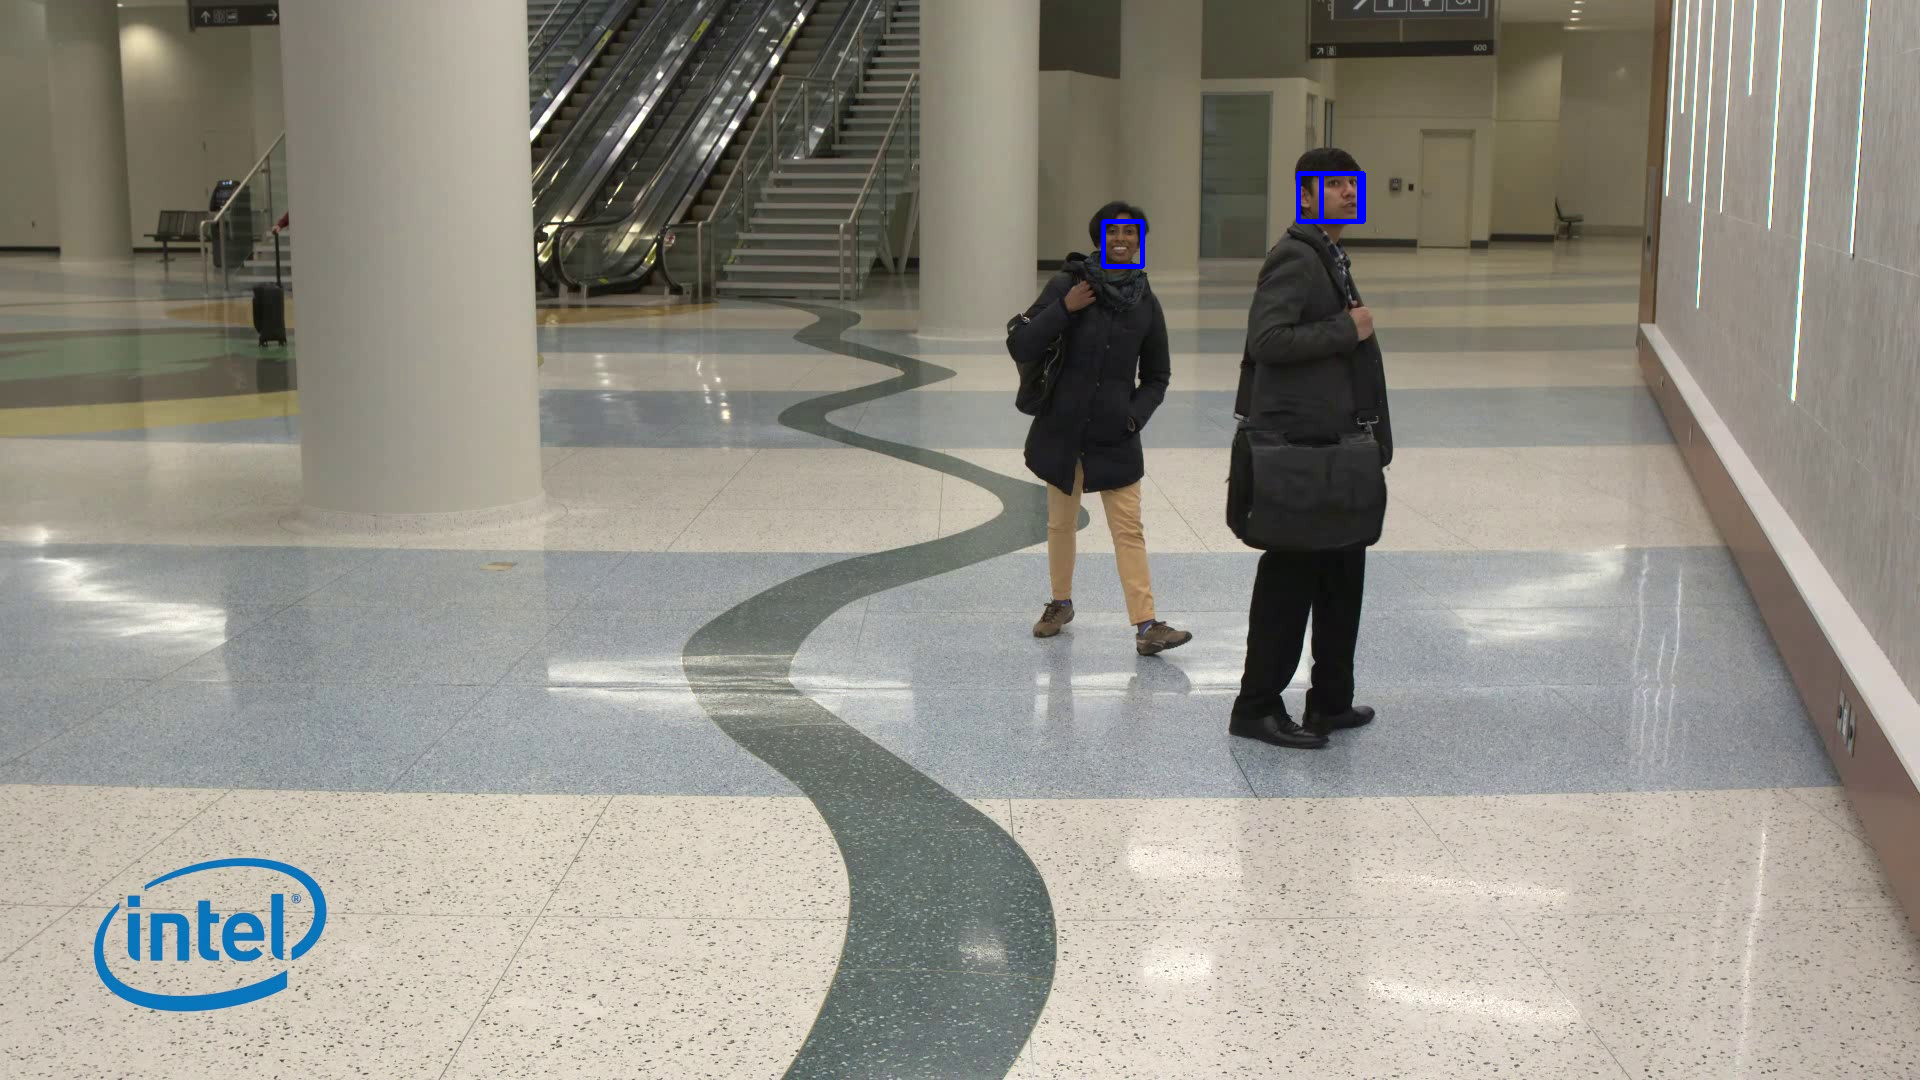

In [23]:
import IPython
import PIL

for predictions, item in zip(predicted_validation_dataset, validation_dataset.with_empty_annotations()):
    image = item.numpy.astype(np.uint8)
    for box in predictions.annotation_scene.shapes:
        x1 = int(box.x1 * image.shape[1])
        x2 = int(box.x2 * image.shape[1])
        y1 = int(box.y1 * image.shape[0])
        y2 = int(box.y2 * image.shape[0])
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 3)  
    IPython.display.display(PIL.Image.fromarray(image))
    break